### Project 3: Prescriber Behavior Analysis
**Overview**
This analysis investigates the relationship between medical specialties and pharmaceutical spending. It segments the French healthcare market into Primary Care and Specialist categories to identify the primary drivers of healthcare costs.

**Objectives:**
1. Categorize Prescribers: Group 30+ medical specialties into Primary Care (GPs) vs. Specialists.

2. Cost vs. Volume Analysis: Compare the high-volume prescriptions of GPs against the high-value (expensive) treatments of Specialists.

3. Policy Insights: Identify high-cost therapeutic areas where biosimilar adoption or price negotiations could optimize the national health budget.


In [1]:
import pandas as pd

# Load the data 
# Using 'sep=;' 
# Using 'decimal=,' so Python knows 38,54 is actually 38.54
df = pd.read_csv('OPEN_MEDIC_2024.csv', 
                 sep=';', 
                 decimal=',', 
                 encoding='latin1')
# Run this immediately after loading your CSV
df.columns = df.columns.str.upper()

# Select relevant col
cols_to_keep = [
    'PSP_SPE',  # This identifies the medical specialty (GP vs. Specialist).
    'L_CIP13',   
    'TOP_GEN',
    'BOITES', # Quantity: Total number of boxes of medication dispensed    
    'REM' # Reimbursement: Actual amount in € paid back by Social Security
]
df = df[cols_to_keep]

# results
print("cleaned data")
print(df.head())


cleaned data
   PSP_SPE                   L_CIP13  TOP_GEN  BOITES     REM
0       99   FLUOGEL GEL DENTAIRE  1        0      14   38,54
1        1  ZYMAFLUOR 0,50MG CPR 100        0      25   13,06
2       99  ZYMAFLUOR 0,50MG CPR 100        0      20   10,18
3        1  ZYMAFLUOR 0,50MG CPR 100        0     114   48,89
4       12  ZYMAFLUOR 0,50MG CPR 100        0     404  157,83


In [2]:
col_to_fix = ['REM']

for col in col_to_fix:
    # Convert to string first
    df[col] = df[col].astype(str)
    
    # Remove any existing dots (thousands separators)
    df[col] = df[col].str.replace('.', '', regex=False)
    
    # Change the French comma to a Python decimal dot
    df[col] = df[col].str.replace(',', '.', regex=False)
    
    # Convert to float, and turn anything that fails into 'NaN' (Empty) 
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.head())

   PSP_SPE                   L_CIP13  TOP_GEN  BOITES     REM
0       99   FLUOGEL GEL DENTAIRE  1        0      14   38.54
1        1  ZYMAFLUOR 0,50MG CPR 100        0      25   13.06
2       99  ZYMAFLUOR 0,50MG CPR 100        0      20   10.18
3        1  ZYMAFLUOR 0,50MG CPR 100        0     114   48.89
4       12  ZYMAFLUOR 0,50MG CPR 100        0     404  157.83


In [3]:
# Create the High-Level Category
def classify_doctor(spe):
    spe = str(spe).upper()
    if '01-' in spe or 'GÉNÉRALE' in spe:
        return 'General Practitioner (GP)'
    else:
        return 'Specialist'

df['Prescriber_Category'] = df['PSP_SPE'].apply(classify_doctor)

In [ ]:
# Aggregate spending and volume
analysis = df.groupby('Prescriber_Category').agg({
    'REM': 'sum',      # Total Reimbursement
    'BOITES': 'sum'    # Total Boxes prescribed
}).reset_index()

# Calculate Cost per Box
analysis['Cost_Per_Box'] = analysis['REM'] / analysis['BOITES']

print("Spending Overview by Category")
print(analysis)

--- Spending Overview by Category ---
  Prescriber_Category           REM      BOITES  Cost_Per_Box
0          Specialist  2.603186e+10  2367965230     10.993344


In [ ]:
# Calculate % of generics prescribed by each group
# TOP_GEN is usually 1 for generics, 0 for princeps
adoption = df.groupby(['Prescriber_Category', 'TOP_GEN'])['BOITES'].sum().unstack()
adoption['Generic_Rate'] = (adoption[1] / (adoption[0] + adoption[1])) * 100

print("Generic Adoption Rate(%)")
print(adoption['Generic_Rate'])


--- Generic Adoption Rate (%) ---
Prescriber_Category
Specialist    49.251457
Name: Generic_Rate, dtype: float64


In [ ]:
# Create a more detailed breakdown to catch those other codes
detail_analysis = df.groupby('PSP_SPE').agg({
    'REM': 'sum',
    'BOITES': 'sum'
}).reset_index()

detail_analysis['Cost_Per_Box'] = detail_analysis['REM'] / detail_analysis['BOITES']

# Get the Top 10 specialties by total spending
top_spenders = detail_analysis.sort_values(by='REM', ascending=False).head(10)

print("Top 10 Spending Specialties")
print(top_spenders)

--- Top 10 Spending Specialties ---
    PSP_SPE           REM      BOITES  Cost_Per_Box
24       90  1.282115e+10   457022421     28.053661
0         1  8.222697e+09  1595758934      5.152844
13       15  7.822346e+08    40369299     19.376967
26       99  6.921004e+08    21253331     32.564327
2         3  4.624093e+08    18282545     25.292393
12       14  4.243089e+08    14269349     29.735687
8         9  3.427689e+08     4433222     77.318230
5         6  2.768638e+08     6298406     43.957753
11       13  2.677627e+08     9916293     27.002294
7         8  2.525549e+08     8149942     30.988552


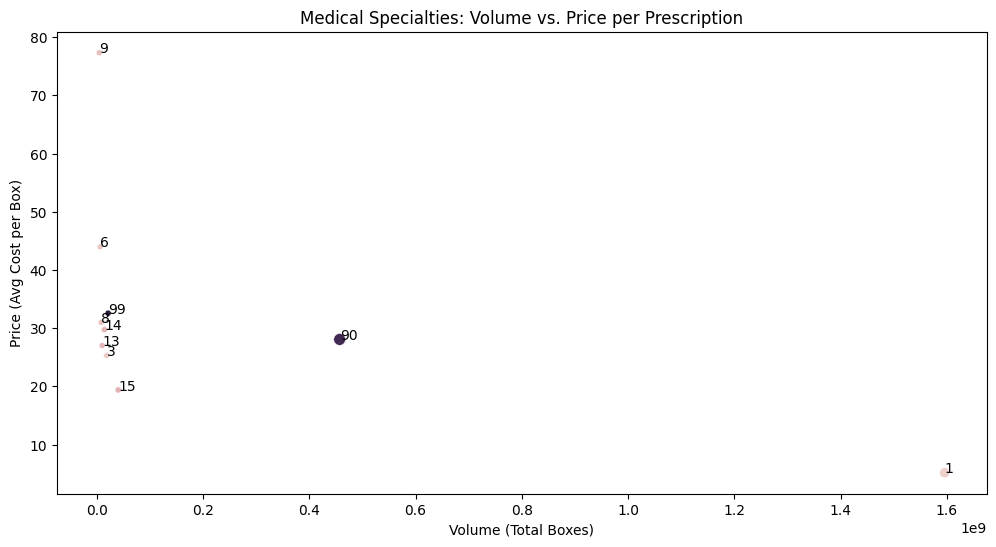

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.scatterplot(data=top_spenders, x='BOITES', y='Cost_Per_Box', size='REM', hue='PSP_SPE', legend=False)

# Annotate the points so we know which specialty is which
for i in range(top_spenders.shape[0]):
    plt.text(top_spenders.BOITES.iloc[i], top_spenders.Cost_Per_Box.iloc[i], top_spenders.PSP_SPE.iloc[i])

plt.title('Medical Specialties: Volume vs. Price per Prescription')
plt.xlabel('Volume (Total Boxes)')
plt.ylabel('Price (Avg Cost per Box)')
plt.show()

In [8]:
# Focus on the #1 spending specialty (Top row of your top_spenders)
top_spe_code = top_spenders.iloc[0]['PSP_SPE']

top_drugs_in_spe = df[df['PSP_SPE'] == top_spe_code].groupby('L_CIP13').agg({
    'REM': 'sum',
    'BOITES': 'sum'
}).sort_values(by='REM', ascending=False).head(5)

print(f"--- Top 5 Drugs for Specialty {top_spe_code} ---")
print(top_drugs_in_spe)

--- Top 5 Drugs for Specialty 90.0 ---
                                          REM  BOITES
L_CIP13                                              
KAFTRIO 100/50/75MG CPR 56       3.986263e+08   42425
VYNDAQEL 61 MG CAPSULE MOLLE 30  3.788177e+08   52598
XTANDI 40MG CPR 112              2.328734e+08   78118
TAGRISSO 80 MG CPR 30            2.203663e+08   42477
KALYDECO 150 MG CPR 28           2.163335e+08   40217


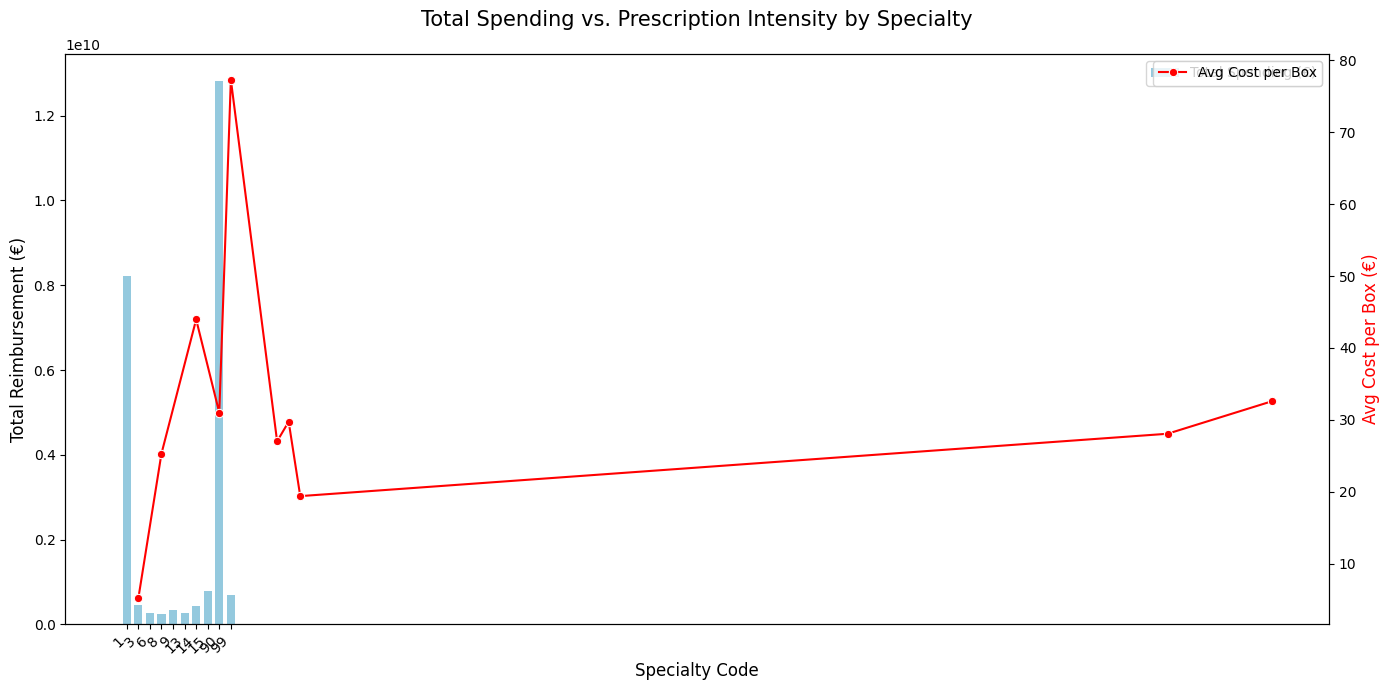

In [29]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# 1. Set width to 0.7 for a perfect balance of broad bars and visible gaps
sns.barplot(
    x='PSP_SPE', 
    y='REM', 
    data=top_spenders, 
    ax=ax1, 
    color='skyblue', 
    label='Total Spending (€)',
    width=0.7  # 0.7 provides a clean gap; 0.9 would be very tight
)

# 2. Improve X-axis label visibility
ax1.set_ylabel('Total Reimbursement (€)', fontsize=12)
ax1.set_xlabel('Specialty Code', fontsize=12)
plt.xticks(rotation=45, ha='right') # 'ha' aligns the labels to the ticks better

# 3. Add the line chart on the secondary axis
ax2 = ax1.twinx()
sns.lineplot(
    x='PSP_SPE', 
    y='Cost_Per_Box', 
    data=top_spenders, 
    ax=ax2, 
    color='red', 
    marker='o', 
    label='Avg Cost per Box'
)
ax2.set_ylabel('Avg Cost per Box (€)', fontsize=12, color='red')

plt.title('Total Spending vs. Prescription Intensity by Specialty', fontsize=15, pad=20)
plt.tight_layout() # Ensures labels and titles fit within the saved image

plt.show()